In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from docs.untitled import fred_api_key
import pandas as pd
import fredapi as fr
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import r2_score,root_mean_squared_error



fred = fr.Fred(fred_api_key)




device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

"""Fed Funds Rate """

ffr = fred.get_series("FEDFUNDS")
ffr.name = "Fed Funds Rate"

data = pd.DataFrame(ffr).dropna()
data = data.reset_index()
data['Date'] = data['index']


data.drop("index",axis=1,inplace=True)
data.head(10)

cuda


,Fed Funds Rate,Date
0,0.80,1954-07-01
1,1.22,1954-08-01
2,1.07,1954-09-01
3,0.85,1954-10-01
4,0.83,1954-11-01
5,1.28,1954-12-01
6,1.39,1955-01-01
7,1.29,1955-02-01
8,1.35,1955-03-01
9,1.43,1955-04-01


In [2]:
data.dropna(inplace=True)
training = data.iloc[:,0:1].values



train_split = int(len(training) * .88)
train_data = training[:train_split]
test_data = training[train_split:]
print(f' Shape of training data: {train_data.shape}')
print(f' Shape of testing data: {test_data.shape}')

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

def slider(dataframe, seq_length):
    X, y = [], []
    for i in range(len(dataframe) - seq_length):
        X_ = dataframe[i:(i + seq_length)]
        y_ = dataframe[i + seq_length]
        X.append(X_)
        y.append(y_)
    return np.array(X), np.array(y)

seq_length = 12

X_train, y_train = slider(train_data, seq_length)
X_test,y_test = slider(test_data,seq_length)


X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()



class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, X):
        h0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        c0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        out, _ = self.lstm(X,(h0, c0))
        out = self.fc(out[:,-1,:])
        return out



bidirectional_lstm = BiLSTM(input_size=1,hidden_size=128,num_layers=2,output_size=1)
epochs = 500
learning_rate = 0.001
bilistm_optimizer = torch.optim.Adam(params=bidirectional_lstm.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()

 Shape of training data: (749, 1)
 Shape of testing data: (103, 1)


In [3]:
for epoch in range(epochs):
    y_pred = bidirectional_lstm(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    bilistm_optimizer.zero_grad()
    loss.backward()
    bilistm_optimizer.step()
    if epoch % 1 != 0:
        continue
    bidirectional_lstm.eval()
    with torch.no_grad():
        y_pred = bidirectional_lstm(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  bidirectional_lstm(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')
        

C:\Users\katsa\AppData\Local\Temp\ipykernel_7708\3037039946.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
C:\Users\katsa\AppData\Local\Temp\ipykernel_7708\3037039946.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.2677; Test RSME: 0.1181
Epoch: 1; train_RSEM: 0.2327; Test RSME: 0.1023
Epoch: 2; train_RSEM: 0.2033; Test RSME: 0.1117
Epoch: 3; train_RSEM: 0.185; Test RSME: 0.1464
Epoch: 4; train_RSEM: 0.1859; Test RSME: 0.1958
Epoch: 5; train_RSEM: 0.1988; Test RSME: 0.2344
Epoch: 6; train_RSEM: 0.2019; Test RSME: 0.2421
Epoch: 7; train_RSEM: 0.1945; Test RSME: 0.2289
Epoch: 8; train_RSEM: 0.1845; Test RSME: 0.2067
Epoch: 9; train_RSEM: 0.1768; Test RSME: 0.1833
Epoch: 10; train_RSEM: 0.173; Test RSME: 0.1627
Epoch: 11; train_RSEM: 0.1721; Test RSME: 0.1462
Epoch: 12; train_RSEM: 0.1725; Test RSME: 0.1342
Epoch: 13; train_RSEM: 0.1728; Test RSME: 0.1261
Epoch: 14; train_RSEM: 0.1722; Test RSME: 0.1214
Epoch: 15; train_RSEM: 0.1702; Test RSME: 0.1194
Epoch: 16; train_RSEM: 0.1668; Test RSME: 0.1198
Epoch: 17; train_RSEM: 0.1622; Test RSME: 0.1224
Epoch: 18; train_RSEM: 0.157; Test RSME: 0.1272
Epoch: 19; train_RSEM: 0.1517; Test RSME: 0.134
Epoch: 20; train_RSEM: 0.1472; Tes

Root Mean Squared Error: 0.01188
R2 Score: 98.68%


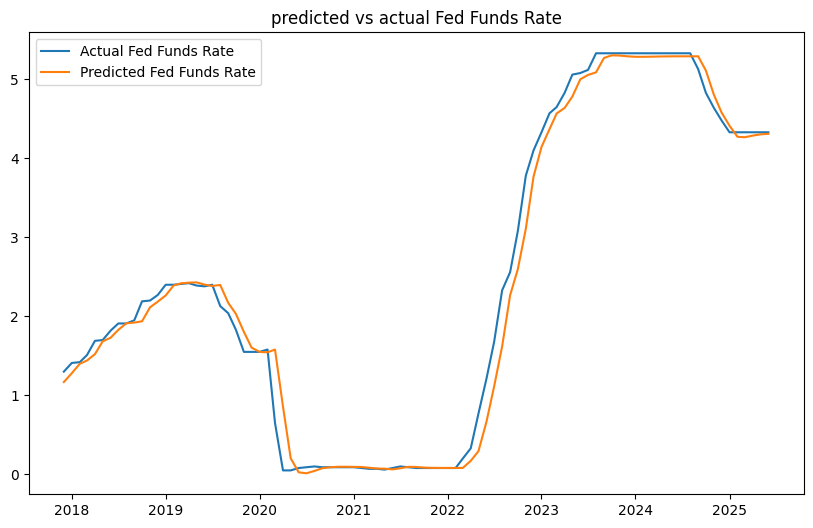

In [6]:
with torch.no_grad():
    pred = bidirectional_lstm(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)




rmse = root_mean_squared_error(y_test_np,pred_np)
r2 = r2_score(y_test_np,pred_np)

print(f'Root Mean Squared Error: {rmse:.4}')
print(f'R2 Score: {r2*100:.2f}%')


test_dates = data.iloc[train_split + seq_length:]['Date']

comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Fed Funds Rate": actual_rescaled.flatten(),
    "Predicted Fed Funds Rate":pred_rescaled.flatten()
})



plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df["Actual Fed Funds Rate"],label="Actual Fed Funds Rate")
plt.plot(comparison_df['Date'],comparison_df['Predicted Fed Funds Rate'],label="Predicted Fed Funds Rate")
plt.title("predicted vs actual Fed Funds Rate")
plt.legend()
plt.savefig("images/predicted-actual-fed-funs-rate.png")
plt.show()

In [7]:
print(comparison_df.head(20))
print(comparison_df.tail(20))

          Date  Actual Fed Funds Rate  Predicted Fed Funds Rate
761 2017-12-01                   1.30                  1.168430
762 2018-01-01                   1.41                  1.280081
763 2018-02-01                   1.42                  1.399598
764 2018-03-01                   1.51                  1.440820
765 2018-04-01                   1.69                  1.521605
766 2018-05-01                   1.70                  1.682960
767 2018-06-01                   1.82                  1.729375
768 2018-07-01                   1.91                  1.829315
769 2018-08-01                   1.91                  1.912287
770 2018-09-01                   1.95                  1.921318
771 2018-10-01                   2.19                  1.937420
772 2018-11-01                   2.20                  2.113562
773 2018-12-01                   2.27                  2.185929
774 2019-01-01                   2.40                  2.264383
775 2019-02-01                   2.40   